In [1]:
from scipy import signal
import numpy as np
from scipy.io import wavfile
import plotly.express as px 
import matplotlib.pyplot as plt

In [2]:
#!pip install plotly

YIN PAPER 
http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf

Explanation: https://www.youtube.com/watch?v=W585xR3bjLM

In [3]:
def f(x):  # Generates Signal
    f_0 = 1
    return np.sin(x*np.pi*2*f_0)

In [4]:
_CMNDF_cache_dict = {}
_DF_cache_dict = {} 
_ACF_cache_dict = {}

def clear_cache_dicts():
    global _CMNDF_cache_dict
    global _DF_cache_dict  
    global _ACF_cache_dict 
    print(len(_DF_cache_dict), len(_CMNDF_cache_dict), len(_ACF_cache_dict))
    _CMNDF_cache_dict.clear()
    _DF_cache_dict.clear() 
    _ACF_cache_dict.clear()
    print(len(_DF_cache_dict), len(_CMNDF_cache_dict), len(_ACF_cache_dict))
    print("hola")

In [5]:
def ACF(f, W, t, lag):
    # Calculates autocorr.
    # f: signal
    # W: window size
    # t: timestep
    # lag: number of samples to shift
    return np.sum(
        f[t: t+W] * f[lag+t:lag+t+W]
    )

def ACF_cache(f, W, t, lag):
    if (t, lag) not in _ACF_cache_dict:
        _ACF_cache_dict[(t, lag)] = np.sum(f[t: t+W] * f[lag+t:lag+t+W])
    return _ACF_cache_dict[(t, lag)]
    

In [6]:
def detect_pitch(f, W, t, sample_rate, bounds):
    # Estimates signal pitch
    # f: signal
    # W: window size
    # t: timestep
    # sample_rate: signal sample rate
    # bounds: range of samples quantity to lag signal.
    ACF_vals = [ACF(f, W, t, i) for i in range(*bounds)]
    sample = np.argmax(ACF_vals)+bounds[0]
    return sample_rate/sample #convert to frequency


In [7]:
# Test
sample_rate = 500 #signal sample rate
start = 0 #signal t0
end = 5 #signal tf
num_samples = int(sample_rate * (end - start) + 1)
window_size = 200 # autcorr window size
bounds = [20, num_samples //2] #from 20 samples lag to half of the signal.
x = np.linspace(start, end, num_samples)
print(detect_pitch(f(x), window_size, 1, sample_rate, bounds))

0.9823182711198428


#### Test with decreasing amplitude signal.

In [8]:
def dicreasing_f(x):  # Generates Signal
    f_0 = 1
    envelope = lambda x: np.exp(-x)
    return np.sin(x*np.pi*2*f_0) * envelope(x)

In [9]:
# Test 2
sample_rate = 500 #signal sample rate
start = 0 #signal t0
end = 5 #signal tf
num_samples = int(sample_rate * (end - start) + 1)
window_size = 200 # autcorr window size
bounds = [20, num_samples //2] #from 20 samples lag to half of the signal.
x = np.linspace(start, end, num_samples)
print(detect_pitch(dicreasing_f(x), window_size, 1, sample_rate, bounds))

25.0


#### Take into account the square when calculating autocorr. If not, negative terms cancel out.

In [10]:
def DF(f, W, t, lag):
    return ACF(f, W, t, 0)+ACF(f, W, t+lag, 0) - (2*ACF(f, W, t, lag))

def DF_cache(f, W, t, lag):
    if (t, lag) not in _DF_cache_dict:
        _DF_cache_dict[(t, lag)] = ACF_cache(f, W, t, 0)+ACF_cache(f, W, t+lag, 0) - (2*ACF_cache(f, W, t, lag))
    return _DF_cache_dict[(t, lag)]

def detect_pitch_square(f, W, t, sample_rate, bounds):
    DF_vals = [DF(f, W, t, i) for i in range(*bounds)]
    sample = np.argmin(DF_vals)+bounds[0]
    return sample_rate/sample

In [11]:
# Test 2
print(detect_pitch_square(dicreasing_f(x), window_size, 1, sample_rate, bounds))

25.0


#### Cumulative mean normalize difference function

In [12]:
def CMNDF(f, W, t, lag):
    if lag == 0:
        return 1
    return DF(f, W, t, lag) / np.sum([DF(f, W, t, j+1) for j in range(lag)])*lag

def CMNDF_cache(f, W, t, lag):
    if lag == 0:
        return 1
    if (lag, t) not in _CMNDF_cache_dict:
        _CMNDF_cache_dict[(lag, t)] = DF_cache(f, W, t, lag) / np.sum([DF_cache(f, W, t, j+1) for j in range(lag)])*lag
    return _CMNDF_cache_dict[(lag, t)]

In [13]:
def detect_pitch_cmndf(f, W, t, sample_rate, bounds, thresh=0.1):
    CMNDF_vals = [CMNDF(f, W, t, i) for i in range(*bounds)]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i+bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals)+bounds[0]
    return sample_rate/sample

def detect_pitch_cmndf_cache(f, W, t, sample_rate, bounds, thresh=0.1):
    CMNDF_vals = [CMNDF_cache(f, W, t, i) for i in range(*bounds, 10)]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i+bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals)+bounds[0]
    return sample_rate/sample

In [14]:
%%time
print(detect_pitch_cmndf(dicreasing_f(x), window_size, 1, sample_rate, bounds))

1.002004008016032
Wall time: 33.3 s


In [15]:
%%time
clear_cache_dicts()
print(detect_pitch_cmndf_cache(dicreasing_f(x), window_size, 1, sample_rate, bounds))

0 0 0
0 0 0
hola
7.352941176470588
Wall time: 112 ms


## with files

In [16]:
sample_rate, data = wavfile.read("assets/tenor.wav")
data = data.astype(np.float64)
min_freq = 20
max_freq = 500
window_size = int(sample_rate // min_freq * 1.2)

min_bound = sample_rate // max_freq
max_bound = sample_rate // min_freq
bounds = [min_bound, max_bound]

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_8344/3361053704.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read("assets/tenor.wav")


1240 123 2481
0 0 0
hola


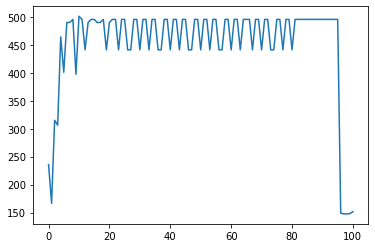

Wall time: 38.9 s


In [17]:
%%time
pitches = []
clear_cache_dicts()
for i in range(data.shape[0] // (window_size+3)):
    pitches.append(
        detect_pitch_cmndf_cache(
            data[:,0],
            window_size,
            i*window_size,
            sample_rate,
            bounds
        ))

plt.plot(pitches)
plt.show()

In [18]:
clear_cache_dicts()

221998 21412 444097
0 0 0
hola


In [19]:
_CMNDF_cache_dict = {}
print(len(_CMNDF_cache_dict))
#_DF_cache_dict = {} 
#_ACF_cache_dict = {}

0


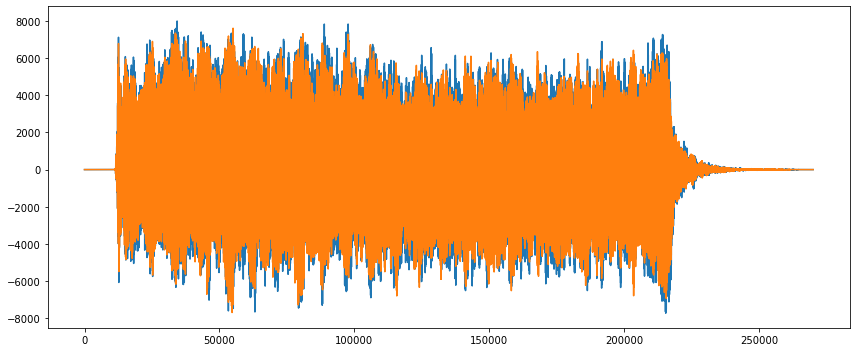

In [20]:
plt.figure(figsize=(12,5))
plt.plot(data)
plt.tight_layout()
plt.show()

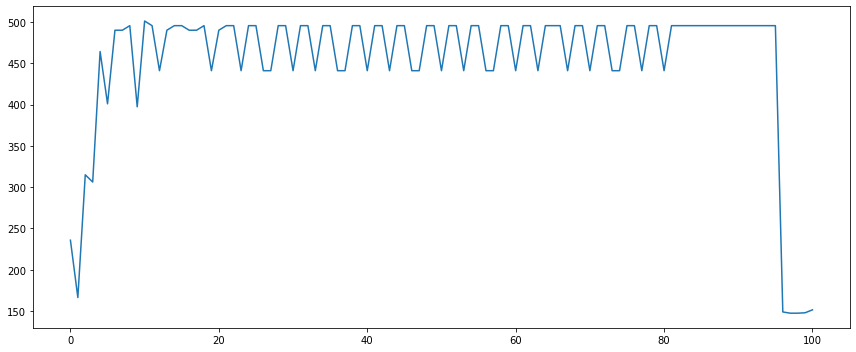

In [21]:
plt.figure(figsize=(12,5))
plt.plot(pitches)
plt.tight_layout()
plt.show()